In [1]:
from google.colab import drive 
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
!unzip /content/gdrive/MyDrive/Dacon/airline/airline_dataset.zip

Archive:  /content/gdrive/MyDrive/Dacon/airline/airline_dataset.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [3]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 1.2 MB/s 


In [99]:
import warnings
warnings.filterwarnings(action='ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from pandas.api.types import is_numeric_dtype, is_categorical_dtype

import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import random

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from tqdm import tqdm
from catboost import CatBoostClassifier

In [78]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

In [5]:
print('===== Load data =====')
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# drop 'id' column
df_train = df_train.drop('id', axis=1)
df_test = df_test.drop('id', axis=1)

print('The shape of train:', df_train.shape)
print('The shape of test :', df_test.shape)
print()

print('===== Split Categorical/Numeric Features =====')
cat_features = [] # categorical features
num_features = [] # numeric features

for f in df_train.columns:
    if df_train[f].nunique() < 10 and f != 'target':
        cat_features.append(f)
        #df_train[f] = df_train[f].astype(np.object)
    else:
        num_features.append(f)


print(f'Categorical Features: size: {len(cat_features)}\n{cat_features}')
print(f'Numeric Features: size: {len(num_features)}\n {num_features}')

===== Load data =====
The shape of train: (3000, 23)
The shape of test : (2000, 22)

===== Split Categorical/Numeric Features =====
Categorical Features: size: 18
['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']
Numeric Features: size: 5
 ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'target']


In [7]:
# replace missing value(0) to NaN(np.nan)
def replace_missing_values(df_input, columns):
    df = df_input.copy()
    df[columns] = df[columns].replace({0:np.nan, '0':np.nan})

    return df


def get_rate(score):
    if score > 3:
        return 'Positive'
    elif score == 3:
        return 'Neutral'
    elif score < 3: # missing value
        return 'Negative'
    else:
        return 'Unknown'


def make_rate_features(df_input, cat_features):
    df = df_input.copy()
    new_cat_features = []

    for f in cat_features:
        if df[f].nunique() > 3:
            df[f'{f}_rate'] = df[f].apply(lambda x: get_rate(x))
            new_cat_features.append(f'{f}_rate')
    
    return df, new_cat_features

In [8]:
print('===== Replace Missing Values =====')
df_train = replace_missing_values(df_train, cat_features)
df_test = replace_missing_values(df_test, cat_features)

print('===== Make rating features =====')
df_train, new_cat_features = make_rate_features(df_train, cat_features)
df_test, new_cat_features = make_rate_features(df_test, cat_features)
print('The shape of df_train', df_train.shape)
print('The shape of df_test', df_test.shape)

===== Replace Missing Values =====
===== Make rating features =====
The shape of df_train (3000, 37)
The shape of df_test (2000, 36)


In [9]:
print(len(new_cat_features), new_cat_features)

cat_features += new_cat_features
print(len(cat_features), cat_features)

14 ['Seat comfort_rate', 'Departure/Arrival time convenient_rate', 'Food and drink_rate', 'Gate location_rate', 'Inflight wifi service_rate', 'Inflight entertainment_rate', 'Online support_rate', 'Ease of Online booking_rate', 'On-board service_rate', 'Leg room service_rate', 'Baggage handling_rate', 'Checkin service_rate', 'Cleanliness_rate', 'Online boarding_rate']
32 ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding', 'Seat comfort_rate', 'Departure/Arrival time convenient_rate', 'Food and drink_rate', 'Gate location_rate', 'Inflight wifi service_rate', 'Inflight entertainment_rate', 'Online support_rate', 'Ease of Online booking_rate', 'On-board service_rate', 'Leg room service_rate', 'Ba

In [11]:
def log_scaling(df_input, columns):
    df = df_input.copy()
    log_columns = []
    for f in columns:
        df[f'{f}_log'] = np.log1p(df[f])
        log_columns.append(f'{f}_log')

    return df, log_columns

In [12]:
print('===== Log scaling =====')
df_train, log_features = log_scaling(df_train, ['Departure Delay in Minutes', 'Arrival Delay in Minutes'])
df_test, log_features = log_scaling(df_test, ['Departure Delay in Minutes', 'Arrival Delay in Minutes'])

print(df_train.shape)
print(df_test.shape)

print(len(log_features))
print(log_features)
num_features += log_features
print(len(num_features))
print(num_features)

===== Log scaling =====
(3000, 39)
(2000, 38)
2
['Departure Delay in Minutes_log', 'Arrival Delay in Minutes_log']
7
['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'target', 'Departure Delay in Minutes_log', 'Arrival Delay in Minutes_log']


In [13]:
rating_features = []
for f in new_cat_features:
    #print(f[:-5]) # remove '_rate'
    rating_features.append(f[:-5])

print(rating_features)

['Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding']


In [14]:
def set_static_features(df_input):
    df = df_input.copy()
    df['rating_mean'] = df.loc[:, rating_features].mean(axis=1)
    df['rating_std'] = df.loc[:, rating_features].std(axis=1)
    df['is_delay'] = np.where(df[log_features[0]] + df[log_features[1]] >= 1, True, False)

    return df

In [15]:
df_train = set_static_features(df_train)
df_test = set_static_features(df_test)

print(df_train.shape)
print(df_test.shape)
df_train.head(2)

(3000, 42)
(2000, 41)


,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,target,Seat comfort_rate,Departure/Arrival time convenient_rate,Food and drink_rate,Gate location_rate,Inflight wifi service_rate,Inflight entertainment_rate,Online support_rate,Ease of Online booking_rate,On-board service_rate,Leg room service_rate,Baggage handling_rate,Checkin service_rate,Cleanliness_rate,Online boarding_rate,Departure Delay in Minutes_log,Arrival Delay in Minutes_log,rating_mean,rating_std,is_delay
0,Female,disloyal Customer,22,Business travel,Eco,1599,3.0,NaN,3.0,3.0,4.0,3.0,4.0,4.0,5.0,4.0,4.0,4.0,5.0,4.0,0,0.0,0,Neutral,Unknown,Neutral,Neutral,Positive,Neutral,Positive,Positive,Positive,Positive,Positive,Positive,Positive,Positive,0.000000,0.000000,3.846154,0.688737,False
1,Female,Loyal Customer,37,Business travel,Business,2810,2.0,4.0,4.0,4.0,1.0,4.0,3.0,5.0,5.0,4.0,2.0,1.0,5.0,2.0,18,18.0,0,Negative,Positive,Positive,Positive,Negative,Positive,Neutral,Positive,Positive,Positive,Negative,Negative,Positive,Negative,2.944439,2.944439,3.285714,1.437336,True


In [29]:
df_train['ages'] = df_train['Age'].apply(lambda x: x // 10 * 10)
df_test['ages'] = df_test['Age'].apply(lambda x: x // 10 * 10)
df_train.head(2)

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,target,Seat comfort_rate,Departure/Arrival time convenient_rate,Food and drink_rate,Gate location_rate,Inflight wifi service_rate,Inflight entertainment_rate,Online support_rate,Ease of Online booking_rate,On-board service_rate,Leg room service_rate,Baggage handling_rate,Checkin service_rate,Cleanliness_rate,Online boarding_rate,Departure Delay in Minutes_log,Arrival Delay in Minutes_log,rating_mean,rating_std,is_delay,ages
0,0,1,22,0,1,1599,2,5,2,2,3,2,3,3,4,3,3,3,4,3,0,0.0,0,1,3,1,1,2,1,2,2,2,2,2,2,2,2,0.000000,0.000000,3.846154,0.688737,False,20
1,0,0,37,0,0,2810,1,3,3,3,0,3,2,4,4,3,1,0,4,1,18,18.0,0,0,2,2,2,0,2,1,2,2,2,0,0,2,0,2.944439,2.944439,3.285714,1.437336,True,30


In [30]:
selected_features = cat_features + num_features + ['rating_mean', 'rating_std'] + ['is_delay'] + ['ages']
print(len(selected_features))

43


# Label Encoding
- missing value 0이 있으므로 Ordinal Encoding은 할 수 없음
- 결측치 처리 대신 NaN으로 처리되기를 기대할 수 있음

In [31]:
le = preprocessing.LabelEncoder()
for f in cat_features:
    df_train[f] = le.fit_transform(df_train[f].astype(str)) 
    df_test[f] = le.fit_transform(df_test[f].astype(str))

print(df_train.shape)
print(df_test.shape)
df_train.head(2)

(3000, 43)
(2000, 42)


,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Seat comfort,Departure/Arrival time convenient,Food and drink,Gate location,Inflight wifi service,Inflight entertainment,Online support,Ease of Online booking,On-board service,Leg room service,Baggage handling,Checkin service,Cleanliness,Online boarding,Departure Delay in Minutes,Arrival Delay in Minutes,target,Seat comfort_rate,Departure/Arrival time convenient_rate,Food and drink_rate,Gate location_rate,Inflight wifi service_rate,Inflight entertainment_rate,Online support_rate,Ease of Online booking_rate,On-board service_rate,Leg room service_rate,Baggage handling_rate,Checkin service_rate,Cleanliness_rate,Online boarding_rate,Departure Delay in Minutes_log,Arrival Delay in Minutes_log,rating_mean,rating_std,is_delay,ages
0,0,1,22,0,1,1599,2,5,2,2,3,2,3,3,4,3,3,3,4,3,0,0.0,0,1,3,1,1,2,1,2,2,2,2,2,2,2,2,0.000000,0.000000,3.846154,0.688737,False,20
1,0,0,37,0,0,2810,1,3,3,3,0,3,2,4,4,3,1,0,4,1,18,18.0,0,0,2,2,2,0,2,1,2,2,2,0,0,2,0,2.944439,2.944439,3.285714,1.437336,True,30


# 상관계수 파악
- target이 있는 마지막 줄에 주목
- Gate location, Flight Distance는 상관계수가 0에 가까움 -> feature 제거 고려?

In [32]:
tmp_feature_dict = {i: 0 for i in selected_features}
del tmp_feature_dict['target']
selected_features = [f for f in tmp_feature_dict.keys()]
print(len(selected_features))

42


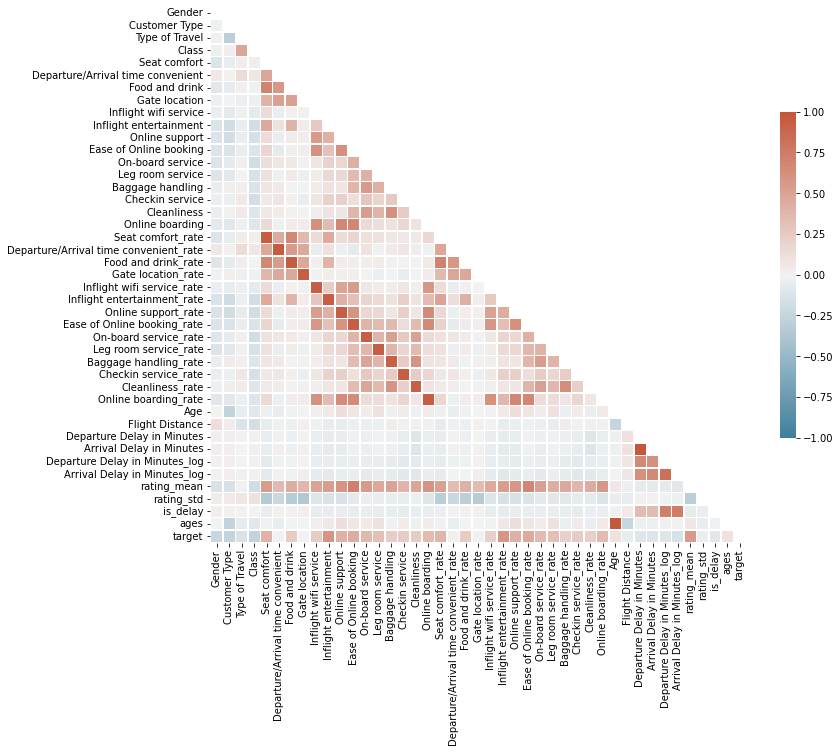

In [33]:
corr = df_train[selected_features + ['target']].corr() # Compute the correlation matrix
mask = np.triu(np.ones_like(corr, dtype=bool))  # Generate a mask for the upper triangle
cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize = (12, 12))
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1., vmax=1., center=0,
                square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.show()

In [82]:
remove_features = []
CORR_THRESHOLD = 0.0

for f in corr.columns[:-1]:
    if np.abs(corr[f]['target']) < CORR_THRESHOLD:
        remove_features.append(f)
print(f'Correlation under {CORR_THRESHOLD}: {len(remove_features)}\n{remove_features}')

tmp_features = {k: 0 for k in selected_features}
for f in remove_features:
    if f in selected_features:
        del tmp_features[f]
final_features = [f for f in tmp_features.keys()]
del tmp_features

print(len(final_features), final_features)

train_set = df_train[final_features + ['target']]
print(train_set.shape)

Correlation under 0.0: 0
[]
42 ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Seat comfort', 'Departure/Arrival time convenient', 'Food and drink', 'Gate location', 'Inflight wifi service', 'Inflight entertainment', 'Online support', 'Ease of Online booking', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Cleanliness', 'Online boarding', 'Seat comfort_rate', 'Departure/Arrival time convenient_rate', 'Food and drink_rate', 'Gate location_rate', 'Inflight wifi service_rate', 'Inflight entertainment_rate', 'Online support_rate', 'Ease of Online booking_rate', 'On-board service_rate', 'Leg room service_rate', 'Baggage handling_rate', 'Checkin service_rate', 'Cleanliness_rate', 'Online boarding_rate', 'Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes', 'Departure Delay in Minutes_log', 'Arrival Delay in Minutes_log', 'rating_mean', 'rating_std', 'is_delay', 'ages']
(3000, 43)


In [111]:
def train_model(config, data, features):
    models = []
    scores = []

    set_seed(config['SEED'])
    folds = StratifiedKFold(n_splits=config['N_SPLITS'], shuffle=True)
    for fold, (train_idx, valid_idx) in enumerate(folds.split(data[features], data['target'])):
        X_train = train_set.loc[train_idx][features]
        y_train = train_set.loc[train_idx]['target']
        X_valid = train_set.loc[valid_idx][features]
        y_valid = train_set.loc[valid_idx]['target']

        model = CatBoostClassifier(**config['params'])
        model.fit(X_train, y_train)
        models.append(model)
        p_valid = model.predict(X_valid)
        acc = accuracy_score(y_valid, p_valid)
        scores.append(acc)
        print(f'#{fold} Accuracy: {acc}')
    print('Accuracy mean:', np.mean(scores))
    return models

In [113]:
SEED = 7777
config = {
    'SEED': SEED,
    'N_SPLITS': 5,
    'params': {
        'silent': True,
        'n_estimators': 5000, 
        'learning_rate': 0.014,
        'random_state': SEED,
        #'min_data_in_leaf': 20,
        #'cat_features': selected_cat_features 
    }, 

}

models = train_model(config, train_set, final_features)

Custom logger is already specified. Specify more than one logger at same time is not thread safe.

#0 Accuracy: 0.9383333333333334
#1 Accuracy: 0.9316666666666666
#2 Accuracy: 0.9366666666666666
#3 Accuracy: 0.9266666666666666
#4 Accuracy: 0.935
Accuracy mean: 0.9336666666666666


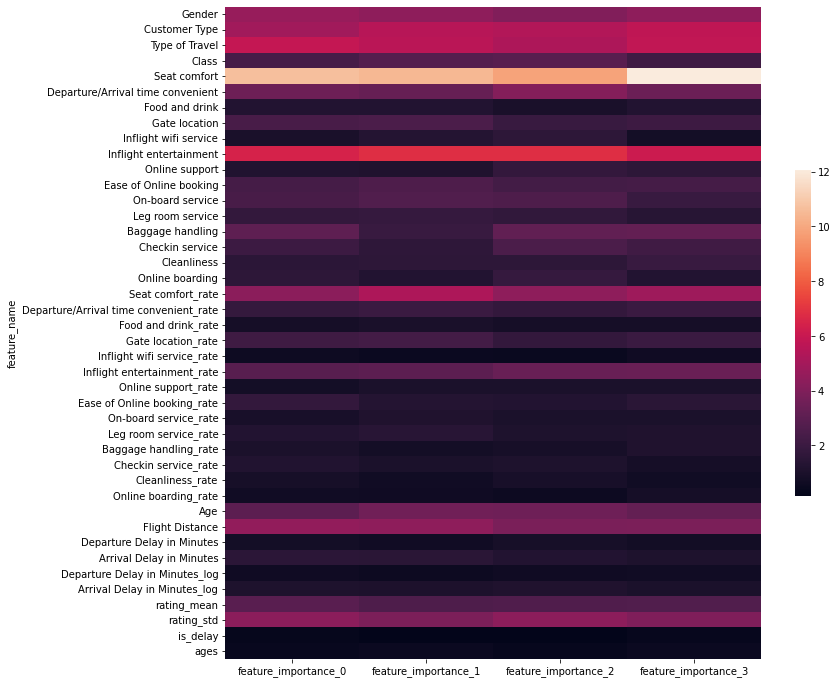

In [114]:
clf = models[-1]
df_fe = pd.DataFrame({
    'feature_name': final_features,
    'feature_importance_0': models[0].feature_importances_,
    'feature_importance_1': models[1].feature_importances_,
    'feature_importance_2': models[2].feature_importances_,
    'feature_importance_3': models[3].feature_importances_,
})
t = df_fe.set_index('feature_name')

plt.figure(figsize = (12, 12))
sns.heatmap(t, cbar_kws={"shrink": .5})
plt.show()
#df_fe.sort_values(by=['feature_importance'], ascending=False)

In [115]:
t['mean'] = t.loc[:, ['feature_importance_0', 'feature_importance_1', 'feature_importance_2', 'feature_importance_3']].mean(axis=1)
t = t.sort_values(by=['mean'], ascending=False)
t

,feature_importance_0,feature_importance_1,feature_importance_2,feature_importance_3,mean
feature_name,,,,,
Seat comfort,10.693794,10.458459,9.863583,12.069794,10.771407
Inflight entertainment,6.450867,6.835548,6.823290,6.119408,6.557278
Type of Travel,5.899981,5.642514,5.257704,5.795609,5.648952
Customer Type,4.924732,5.525096,5.403294,5.789246,5.410592
Seat comfort_rate,4.312117,5.250747,4.436086,4.837798,4.709187
Gender,4.658986,4.434859,4.059534,4.420023,4.393350
Flight Distance,4.510900,4.404188,3.861617,3.887891,4.166149
rating_std,4.322120,3.921203,4.395073,3.988698,4.156774
Departure/Arrival time convenient,3.505778,3.324471,4.147138,3.464093,3.610370


In [97]:
important_features = t.index[:int(len(t) * 0.8)]
print(important_features)

Index(['Seat comfort', 'Inflight entertainment', 'Type of Travel',
       'Customer Type', 'Seat comfort_rate', 'Gender', 'Flight Distance',
       'rating_std', 'Departure/Arrival time convenient', 'Age',
       'Inflight entertainment_rate', 'Baggage handling', 'rating_mean',
       'Class', 'On-board service', 'Ease of Online booking', 'Gate location',
       'Checkin service', 'Gate location_rate',
       'Departure/Arrival time convenient_rate', 'Leg room service',
       'Cleanliness', 'Online boarding', 'Ease of Online booking_rate',
       'Online support', 'Arrival Delay in Minutes', 'Leg room service_rate',
       'Food and drink', 'Inflight wifi service',
       'Arrival Delay in Minutes_log', 'Checkin service_rate',
       'On-board service_rate', 'Baggage handling_rate'],
      dtype='object', name='feature_name')


In [117]:
# config = {
#     'SEED': SEED,
#     'N_SPLITS': 5,
#     'params': {
#         'silent': True,
#         'n_estimators': 5000, 
#         'learning_rate': 0.014,
#         'random_state': SEED,
#         #'min_data_in_leaf': 20,
#         #'cat_features': selected_cat_features 
#     }, 

# }

# models = train_model(config, train_set, important_features)

In [116]:
probs = []
for model in models:
    prob = model.predict_proba(df_test[final_features])
    probs.append(prob)

pred = sum(probs) / len(probs)
pred = np.argmax(pred, axis=1)

df_submit = pd.read_csv('sample_submission.csv')
df_submit['target'] = pred
df_submit.to_csv('/content/gdrive/MyDrive/Dacon/airline/0217_ver3.csv', index=False)